# 逆張りのシグナル判定（ブログ用）

In [1]:
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import yfinance as yf
import talib
import pandas_ta as ta
import pickle
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

## シグナル判定で用いる関数の定義

In [2]:
# クロスオーバーとクロスアンダー関数
def crossover(series1, series2):
    # Ensure the inputs are numpy arrays for element-wise operations
    series1 = np.array(series1)
    series2 = np.array(series2)
    # Calculate the crossover: (previous series1 < previous series2) and (current series1 > current series2)
    cross = (series1[:-1] < series2[:-1]) & (series1[1:] > series2[1:])
    # Append a False at the start since there is no crossover detection at the first element
    return np.append(False, cross)

def overthreshold(series1, x):
    series1 = np.array(series1)
    series2 = np.full(series1.shape[0], x)
    # Calculate the crossover: (previous series1 < previous series2) and (current series1 > current series2)
    cross = (series1[:-1] < series2[:-1]) & (series1[1:] > series2[1:])
    # Append a False at the start since there is no crossover detection at the first element
    return np.append(False, cross)

def crossunder(series1, series2):
    # Ensure the inputs are numpy arrays for element-wise operations
    series1 = np.array(series1)
    series2 = np.array(series2)
    # Calculate the crossunder: (previous series1 > previous series2) and (current series1 < current series2)
    cross = (series1[:-1] > series2[:-1]) & (series1[1:] < series2[1:])
    # Append a False at the start since there is no crossunder detection at the first element
    return np.append(False, cross)

def underthreshold(series1, x):
    series1 = np.array(series1)
    series2 = np.full(series1.shape[0], x)
    # Calculate the crossunder: (previous series1 > previous series2) and (current series1 < current series2)
    cross = (series1[:-1] > series2[:-1]) & (series1[1:] < series2[1:])
    # Append a False at the start since there is no crossunder detection at the first element
    return np.append(False, cross)

## シグナル判定をする戦略の定義

In [3]:
# ボリンジャーバンドの逆張り戦略によるシグナル判定
def bollinger(df,bollingerLength=20):
    # create dataframe
    df1 = df.copy()
    # calculate Bollinger Bands
    df1["upperband"], df1["middleband"], df1["lowerband"] = talib.BBANDS(df1["Close"], \
                        timeperiod=bollingerLength, nbdevup=2, nbdevdn=2, matype=0)
    # BUY signal conditions
    df1['BOL_buySignal'] = crossunder(df1['Close'], df1['lowerband'])
    # SELL signal conditions
    df1['BOL_sellSignal'] = crossover(df1['Close'], df1['upperband'])
    # return dataframe
    return df1.loc[:, ['timestamp','ticker','BOL_buySignal','BOL_sellSignal']]

In [4]:
# RSIとストキャスティクスによるシグナル判定
# https://medium.com/@wl8380/combining-rsi-stochastic-a-trading-strategy-that-can-work-wonders-29041d0553ed
def rsi_stoch(df,rsiLength=14,r_lower=30,r_upper=70,fastk_n=14):
    # create dataframe
    df1 = df.copy()
    # calculate RSI
    df1["RSI"] = talib.RSI(df1["Close"], timeperiod=rsiLength)
    # calculate stochastics
    df1["slowk"], df1["slowd"] = talib.STOCH(df1["High"], df1["Low"], df1["Close"], \
            fastk_period=fastk_n, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    # BUY signal condition
    df1['RSI_buySignal'] = underthreshold(df1['RSI'], r_lower)
    df1['STOCH_buySignal'] = (df1["slowd"] < 20) & crossover(df1["slowk"],df1["slowd"])
    # SELL signal condition
    df1['RSI_sellSignal'] = overthreshold(df1['RSI'], r_upper)
    df1['STOCH_sellSignal'] = (df1["slowd"] > 80) & crossunder(df1["slowk"],df1["slowd"])
    # return dataframe
    return df1.loc[:, ['timestamp','ticker','RSI_buySignal','RSI_sellSignal','STOCH_buySignal','STOCH_sellSignal']]

In [5]:
# ケルトナー及びWilliam's Rの逆張り戦略によるシグナル判定
def kelt_willr(df):
    # create dataframe
    df1 = df.copy()
    # ケルトナーチャンネルを計算 (pandas_ta利用)
    # デフォルトでは、期間=20、ATRの乗数=2
    kc = ta.kc(df1['High'], df1['Low'], df1['Close'])
    # 計算結果を元のDataFrameに結合
    df1 = pd.concat([df1, kc], axis=1)
    # calculate William R
    df1["WillR"] = talib.WILLR(df1["High"], df1["Low"], df1["Close"], timeperiod=14)
    # BUY signal conditions
    df1['Kelt_buySignal'] = crossunder(df1['Close'], df1['KCLe_20_2'])
    df1['WillR_buySignal'] = underthreshold(df1['WillR'], -80)
    # SELL signal conditions
    df1['Kelt_sellSignal'] = crossover(df1['Close'], df1['KCUe_20_2'])
    df1['WillR_sellSignal'] = overthreshold(df1['WillR'], -20)
    # return dataframe
    return df1.loc[:, ['timestamp','ticker','Kelt_buySignal','Kelt_sellSignal',\
                       'WillR_buySignal','WillR_sellSignal']]

## 評価する銘柄のリストと評価期間を指定

In [6]:
# 評価する銘柄のリスト
list_ticker = ['1605.T','4755.T','6954.T','7203.T','9101.T','9983.T','9984.T']
# str_prodはデータを取得する期間（例: 1d、5d、1mo、3mo、1y、2y、5y、10y、ytd、max）
str_prod = "18mo"
# str_itvlはデータの間隔（例: 1m、2m、5m、15m、30m、60m、90m、1h、1d、5d、1wk、1mo、3mo）
str_itvl = "1d"

In [7]:
# 特定の銘柄のデータを取り出す
focus_ticker = '1605.T'

In [8]:
# 各銘柄についてシグナル判定を行い結果を縦連結する
df0 = pd.DataFrame()
for ticker in list_ticker:
    # yahooサイトからデータをダウンロード
    data = yf.download(ticker, period=str_prod, interval=str_itvl, multi_level_index=False)
    data['ticker'] = ticker
    df = data.reset_index().rename(columns={'Date':'timestamp'})
    # ボリンジャーバンドの逆張り戦略によるシグナル判定の実施
    df_boll = bollinger(df)
    # シグナル判定結果を元データに横連結する
    df = df.merge(df_boll, how="inner", on=['timestamp','ticker'])
    # RSIとStochの戦略によるシグナル判定の実施
    df_rsi_stoch= rsi_stoch(df,r_lower=30,r_upper=70)
    # シグナル判定結果を元データに横連結する
    df = df.merge(df_rsi_stoch, how="inner", on=['timestamp','ticker'])
    # ケルトナー及びWilliamRの逆張り戦略によるシグナル判定の実施
    df_kelt_willr= kelt_willr(df)
    # シグナル判定結果を元データに横連結する
    df = df.merge(df_kelt_willr, how="inner", on=['timestamp','ticker'])
    # 一銘柄のシグナル判定結果を元のデータに縦連結する
    df0 = pd.concat([df0,df],axis=0)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## 終値とシグナルの描画

In [9]:
def signal_plot(df0, ticker, str_osc, str_title):
    df = df0[df0['ticker'].str.contains(ticker)]
    # 終値と各種指標のプロット
    plt.figure(figsize=(10, 5))
    plt.plot(df['timestamp'], df['Close'], label='Close Price')
    # 売買ポジションのプロット
    plt.scatter(df['timestamp'][df[f"{str_osc}_buySignal"]], df['Close'][df[f"{str_osc}_buySignal"]], color='green', label='Buy position', marker="^", s=100)
    plt.scatter(df['timestamp'][df[f"{str_osc}_sellSignal"]], df['Close'][df[f"{str_osc}_sellSignal"]], color='red', label='Sell position', marker="v", s=100)
    # 凡例の表示
    plt.legend()
    # 軸ラベルとタイトル
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(focus_ticker + f" {str_title} Strategy")
    # チャートの表示
    plt.show()

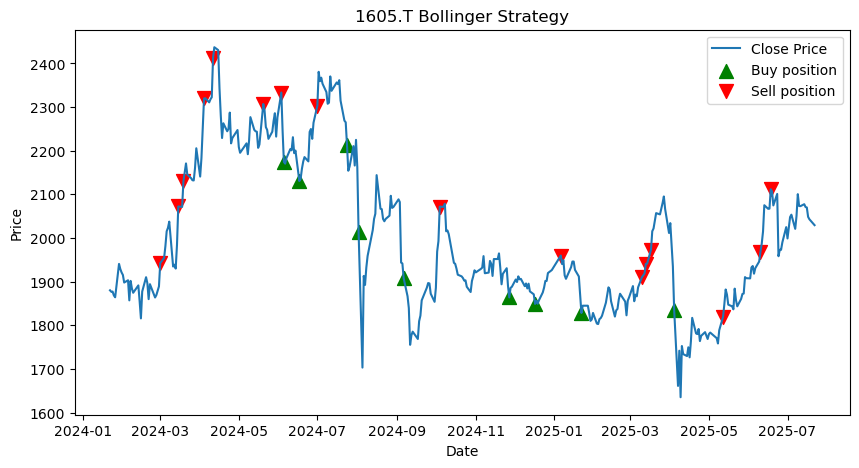

In [10]:
signal_plot(df0, focus_ticker, 'BOL', 'Bollinger')

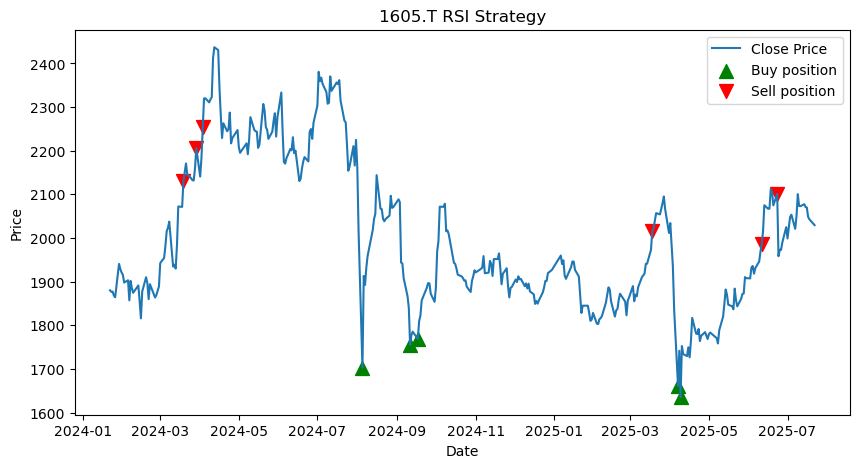

In [11]:
signal_plot(df0, focus_ticker, 'RSI', 'RSI')

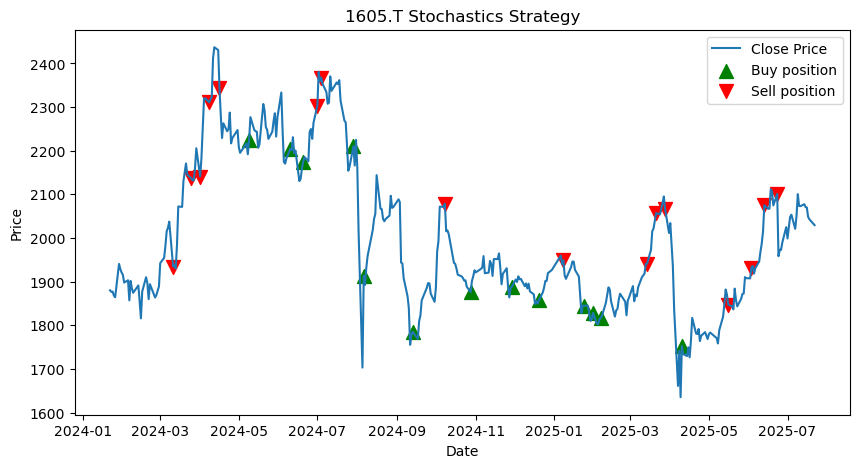

In [12]:
signal_plot(df0, focus_ticker, 'STOCH', 'Stochastics')

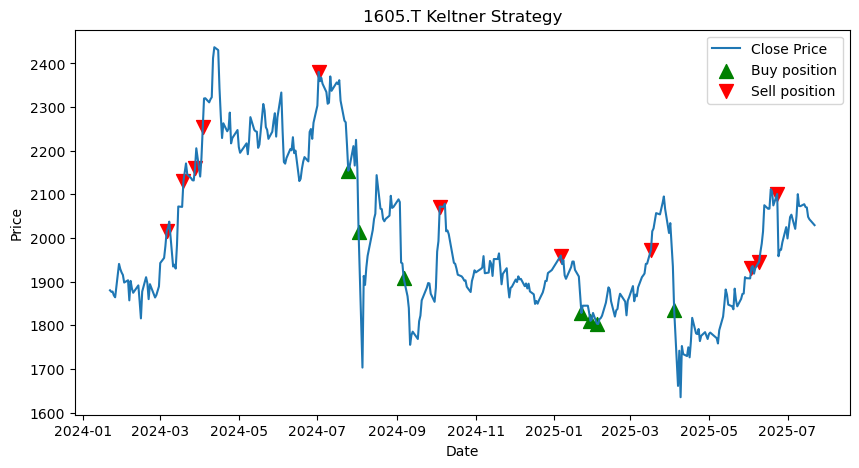

In [13]:
signal_plot(df0, focus_ticker, 'Kelt', 'Keltner')

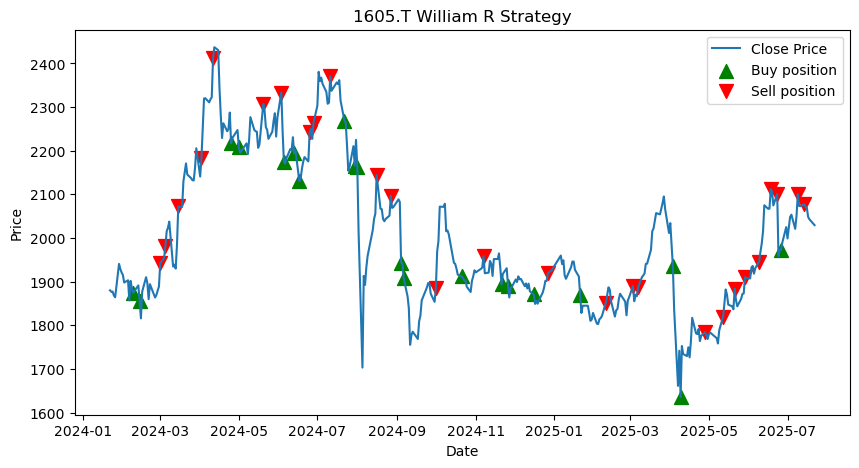

In [14]:
signal_plot(df0, focus_ticker, 'WillR', 'William R')